In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import requests

In [2]:
# Options
pd.set_option('max_colwidth', 500)


In [69]:
df = pd.read_csv('./data/transactions.csv', low_memory=False)

df.head()


,block_time,block_number,hash,value,tx_fee,nonce,from,to,method_id,sender,receiver,project,token_bought_symbol,token_sold_symbol,token_bought_amount,token_sold_amount,amount_usd,taker,tx_from,tx_to
0,2023-04-14 14:51:35.000 UTC,17046105.0,0x2afae7763487e60b893cb57803694810e6d3d136186a6de6719921afd7ca304a,0,0.037013,0.0,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,NaN,0x60806040,0x0000000000000000000000000000000000000000,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-14 16:20:47.000 UTC,17046538.0,0xb38bba8bf8f61029a31e027c37fbc1065db784a39501d456a05cc490db5b4578,0,0.001861,3.0,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0x6982508145454ce325ddbe47a25d4ec3d2311933,0xa9059cbb,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0x92fb5b4f8030103e0b11275c30965d1897ff23e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-14 17:21:11.000 UTC,17046833.0,0x273894b35d8c30d32e1ffa22ee6aa320cc9f55f2adbba0583594ed47c031f6f6,2000000000000000000,0.077539,4.0,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xf305d719,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-14 17:34:47.000 UTC,17046900.0,0xc3760b499850b19d8f266dc10349d70f69c91698233697cbad2ee90ff957ed17,1000000000000000,0.004451,5.0,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x3593564c,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,uniswap-2,PEPE,WETH,1.951464e+11,0.001,2.079390,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0xfbfeaf0da0f2fde5c66df570133ae35f3eb58c9a,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b
4,2023-04-14 19:46:59.000 UTC,17047545.0,0x08153c0546e4f73b178edae90d1e30fb519c7c49ff0dcd00e4b0bcd74dab468c,13000034453500519,0.009752,12056.0,0xaf2358e98683265cbd3a48509123d390ddf54534,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7ff36ab5,0xa43fe16908251ee70ef74718545e4fe6c5ccec9f,0xaf2358e98683265cbd3a48509123d390ddf54534,uniswap-2,PEPE,WETH,2.519324e+12,0.013,27.131592,0xaf2358e98683265cbd3a48509123d390ddf54534,0xaf2358e98683265cbd3a48509123d390ddf54534,0x7a250d5630b4cf539739df2c5dacb4c659f2488d


In [4]:
# Helper Functions
def fetch_token_price(token_symbol):
  api = 'https://min-api.cryptocompare.com/data/price'
  res = requests.get('{}?fsym={}&tsyms=USD'.format(api, token_symbol)).json()
  if 'USD' in res:
    return res['USD']
  else:
    return 0

def fetch_text_signature(hex_signature):
  if len(hex_signature) != 10:
    return ''
  
  api = 'https://www.4byte.directory/api/v1/signatures'
  res = requests.get('{}/?hex_signature={}'.format(api, hex_signature)).json()
  
  if res['count'] == 0:
    return ''
  
  return res['results'][len(res['results']) - 1]['text_signature']


In [71]:
# Overview
start_time = df['block_time'].iloc[0]
end_time = df['block_time'].iloc[-1]
start_block = int(df['block_number'].iloc[0])
end_block = int(df['block_number'].iloc[-1])
total_transasctions = df['hash'].unique().size
total_wallet = df['from'].unique().size
total_eth_paid = round(df.drop_duplicates(['hash'])['tx_fee'].sum(), 2)
current_eth_price = fetch_token_price('ETH')
total_trading_volume = round(df['amount_usd'].sum())

print('Overview:')
print('Time: {} to {}'.format(start_time, end_time))
print('Block: {} to {} ~{} blocks'.format(start_block, end_block, end_block - start_block))
print('Total transasctions: {:,} transactions'.format(total_transasctions))
print('Total unique user: {:,} users'.format(total_wallet))
print('Total fee paid: {:,} ETH ~${:,}'.format(total_eth_paid, round(total_eth_paid * current_eth_price)))
print('Total trading volume: ${:,}'.format(total_trading_volume))


Overview:
Time: 2023-04-14 14:51:35.000 UTC to 2023-05-05 18:06:23.000 UTC
Block: 17046105 to 17196108 ~150003 blocks
Total transasctions: 539,497 transactions
Total unique user: 129,047 users
Total fee paid: 7,564.93 ETH ~$13,728,457
Total trading volume: $2,939,838,678


In [118]:
# Fresh bird: Wallet with the first swap transaction
minimum_nonce = 0
df_drop_duplicate_hahs = df.drop_duplicates(['hash'])
df_fresh_bird = df_drop_duplicate_hahs[
  (df_drop_duplicate_hahs['nonce'] <= minimum_nonce)
  & (df_drop_duplicate_hahs['project'].notnull())
  & (df_drop_duplicate_hahs['token_bought_symbol'] == 'PEPE')
]
number_of_fresh_bird = df_fresh_bird['from'].unique().size

print('{:,} fresh wallets '.format(number_of_fresh_bird))

# Early bird: Buy after liquidity was added on the first day
df_early_bird = df_fresh_bird[df_fresh_bird['block_time'] < '2023-04-15 15:00:00.000 UTC']
number_of_early_bird_wallet = df_early_bird['from'].unique().size
print('{:,} freshest wallets '.format(number_of_early_bird_wallet))
print('Example:')
print (df_early_bird['from'].head(10))


19,770 fresh wallets 
61 freshest wallets 
Example:
5     0xf5c0cdb9e18a4af157fdd369540ec9f4912b5edf
6     0x8ccf59bc5daafc43ff67f9825f08bbfbabc5cef6
7     0x1298652974068e0d3a7bcdd6e29d6409101833ac
8     0xe7a63eb84850f42b5e54a8a24a8cb4fdbf2be1f8
9     0x3191203c8a89d71a8f5a35140e2c7f2477396c92
13    0x08f120a352c16ab1d58bca16f845377e087e9e4c
16    0xb1b15945842b4b68565caa2f10dad59b6d66e5c6
17    0xb903e91bc67fa5c08ea151b17447a5b775eb7fe9
18    0x36c2b911fb9152f077ac26d4e67c7cbdf3b615a9
19    0x5979ce78d9d25e3c6ca5422dd3a8abf3133ba7b8
Name: from, dtype: object


In [34]:
def transfer_to_edges(arr):
  edges = []
  tg = arr[0] if len(arr[0]) < 42 else arr[0][:6]
  for i in range(len(arr) - 1):
    fr = arr[i + 1][:6]
    edges.append((fr, tg))

  return edges

g_group_1 = transfer_to_edges(
  [
    '0x5e74714501f7f2f8e7c3397c796189484e5304ee', # Related mobdad.eth
    '0xf5c0cdb9e18a4af157fdd369540ec9f4912b5edf',
    '0xe7a63eb84850f42b5e54a8a24a8cb4fdbf2be1f8',
    '0x8ccf59bc5daafc43ff67f9825f08bbfbabc5cef6',
    '0xe46b6fef0daa72dfab6ab5f430c635997d9f4bb9',
    '0x9bd5c8bfbe7e0fd78693f1f7e5b3610bdda9d5aa',
    '0x1298652974068e0d3a7bcdd6e29d6409101833ac',
    '0x3ad3940b5a56f86a181f7989045b2c7deb7f8356', # -> 0xf8684b3a3de555d977603558770c9d5127986e4a (Funded by mobdad.eth)
    '0xf8684b3a3de555d977603558770c9d5127986e4a',
    '0x1b5cec47f48d69d89eaa435149954115206303f7',
    '0x6da1fd46ba1044b5a40e0e4258e01ce19ab231ce',
    '0x7b7e034162139c507455e70adabdbd5c204e3a98',
    '0x2ce25fb6f4df177da6fe974638f728eabac5e3b6',
    '0xf03771f583c78f476e3f8c957e79c134f4fdc351'
  ]
)

g_group_2 = transfer_to_edges(
  [
    'Houbi',
    '0x5dd3e5931da643daa2f5ac322503757225566c29',
    '0x2a81048da186e75865605a2e10ae663f8d63003d',
    '0xb71bce9ec5d0a66215a032d6daa83e743eeef380',
    '0xb1f06a0f6154df25dba5033ea04782031495cdc8',
    '0x15ddbc80da895519a90625bd6210671298f76769',
    '0x3ca3a6d10a8489d17c31f591930940c3da70f9fd',
    '0x946990daabd864c3d96ec0ffc59335f4e25696ae',
    '0x4e9d602c1bc0dfd59ea37a67824f505dd1f659b8',
    '0x674891702311283baabd9238d3757588979cbaab',
    '0xcbcb59bb755ce859568733679ce3e5f23c3445a9',
    '0x2b230e525a116e85df9af3b1357834d33bc3dff8',
    '0x48c831676ca4188c0c10563733baa97c088a5b53',
    '0xad106e36fb4e94387f85342d9d9c31aaf5ce293b',
    '0xde85bb9a4f3b414518649f2804e01860063bf11d',
    '0xb0e0864e63cda1ae4b09bb9e0365fb3d1921197d'
  ]
)

g_group_3 = transfer_to_edges(
  [
    'Bybit', # Related badussy.eth, peppertokenerc.eth
    '0x08f120a352c16ab1d58bca16f845377e087e9e4c',
    '0xb1b15945842b4b68565caa2f10dad59b6d66e5c6', # -> 0xd571e1ea0bdb88569af3df6a72e94606006bbc79 (Funded by badussy.eth)
    '0xb903e91bc67fa5c08ea151b17447a5b775eb7fe9',
    '0xb790ee1a15964569573f3105c26033c3353a5f17',
    '0x26e2c9c8629fcb13d0b30db6447e577816ddd805',
    '0x19848274b125f4f75c6d0524f5196473c023d21a',
    '0xdfd45debf66d2f352cd1cdab260c9ef70ab8fe9d'
  ]
)


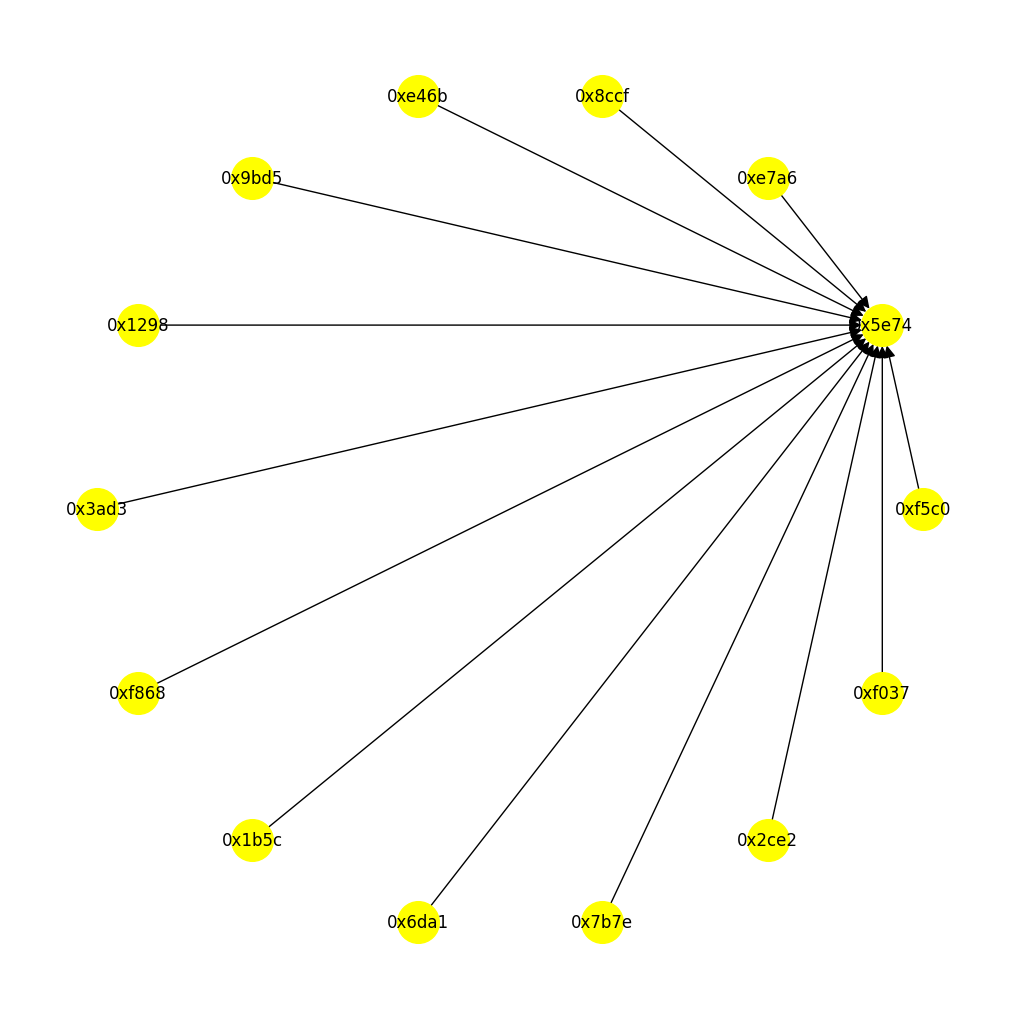

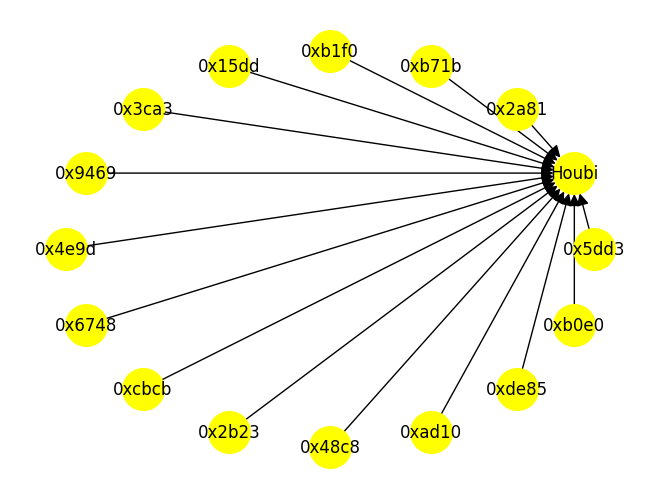

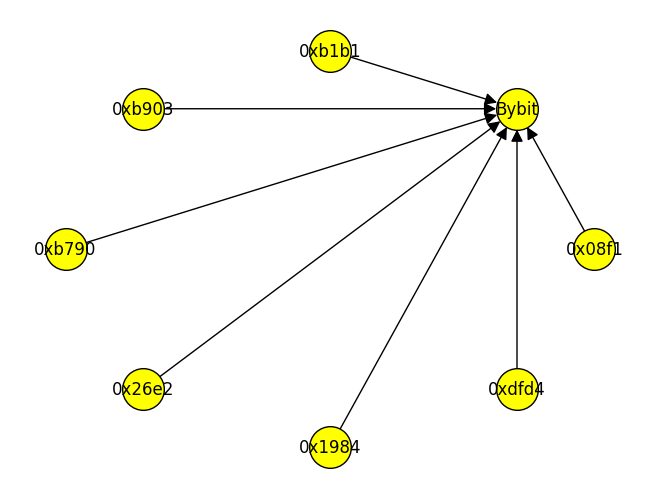

In [39]:
# Related bird?
plt.figure(figsize=(10, 10))
G1 = nx.DiGraph(directed=True)
G2 = nx.DiGraph(directed=True)
G3 = nx.DiGraph(directed=True)

G1.add_edges_from(g_group_1)
G2.add_edges_from(g_group_2)
G3.add_edges_from(g_group_3)

options = {
  'node_color': 'yellow',
  'node_size': 900,
  'width': 1,
  'arrowstyle': '-|>',
  'arrowsize': 18
}

plt.figure(1)
nx.draw(G1, nx.circular_layout(G1), with_labels=True, arrows=True, **options)

plt.figure(2)
nx.draw(G2, nx.circular_layout(G2), with_labels=True, arrows=True, **options)

plt.figure(3)
nx.draw(G3, nx.circular_layout(G3), with_labels=True, arrows=True, **options)

ax = plt.gca()
ax.collections[0].set_edgecolor('#000000')

plt.show()

        method_id  number_call       method_text
4136   0x3593564c       262524           execute
5527   0x5f575529        63801              swap
8299   0xa9059cbb        56376          transfer
5374   0x5ae401dc        15403         multicall
2237   0x04e45aaf        11474  exactInputSingle
8590   0xac9650d8        10929         multicall
5440   0x5cf54026         8909       proxiedSwap
10150  0xe21fd0e9         7513              swap
2260   0x0502b1c5         4164           unoswap
6923   0x8af033fb         3355    swapSimpleMode


<Axes: title={'center': 'Number of calls by Method'}, xlabel='Method', ylabel='Number of calls'>

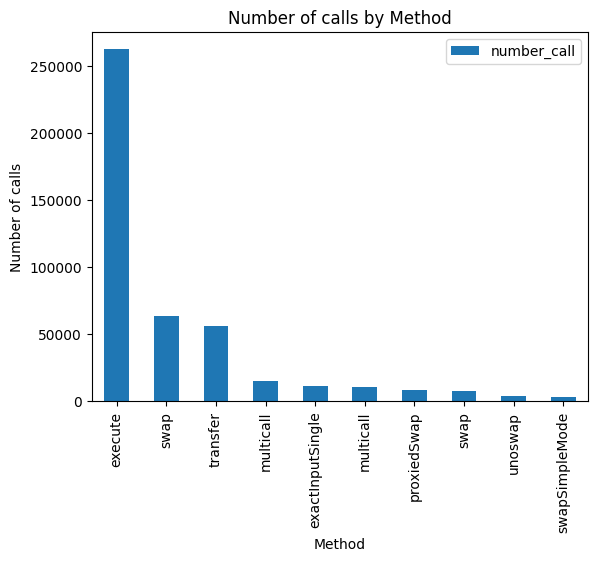

In [7]:
# Count method id
def get_text_signature(method_id):
  text = fetch_text_signature(method_id)
  text = text.split('(')[0]
  return text

df_methods = df.groupby(['method_id'])['method_id'] \
  .count() \
  .reset_index(name='number_call') \
  .sort_values(['number_call'], ascending=False) \
  .head(10)

df_methods['method_text'] = df_methods.apply(lambda x: get_text_signature(x['method_id']), axis=1)

print(df_methods)
df_methods.plot(
  kind='bar',
  title='Number of calls by Method',
  x='method_text',
  y='number_call',
  xlabel='Method',
  ylabel='Number of calls'
)


In [8]:
# Format block time
columns = [
  'block_time',
  'hash',
  'project',
  'token_bought_symbol',
  'token_sold_symbol',
  'token_bought_amount',
  'token_sold_amount',
  'amount_usd'
]
df_with_floor_time_by_hour = df.loc[:, columns]
df_with_floor_time_by_hour['block_time'] = pd \
  .to_datetime(df_with_floor_time_by_hour['block_time']) \
  .dt.floor('H') \
  .dt.strftime('%Y-%m-%d %H:%M:%S')

df_with_floor_time_by_day = df_with_floor_time_by_hour.loc[:]
df_with_floor_time_by_day['block_time'] = pd \
  .to_datetime(df_with_floor_time_by_day['block_time']) \
  .dt.floor('D') \
  .dt.strftime('%Y-%m-%d')


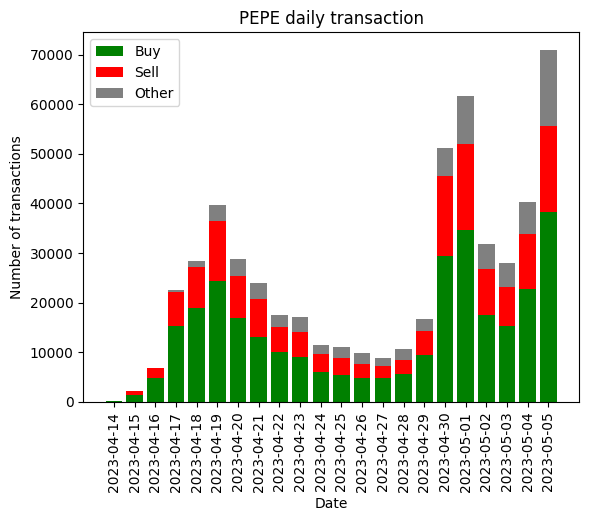

In [9]:
# Daily transaction
def get_other_count(row):
  return row['total_tx_count'] - row['tx_buy_count'] - row['tx_sell_count']

df_tx = df_with_floor_time_by_day.drop_duplicates(['hash'])
df_tx_count = df_tx \
  .groupby('block_time')['hash'] \
  .count() \
  .reset_index(name='total_tx_count')

df_swap_only = df_tx[df_tx['project'].notna()]
df_buy_count = df_swap_only \
  .groupby('block_time')['token_bought_symbol'] \
  .apply(lambda x: (x == 'PEPE').sum()) \
  .reset_index(name='tx_buy_count')

df_sell_count = df_swap_only \
  .groupby('block_time')['token_sold_symbol'] \
  .apply(lambda x: (x == 'PEPE').sum()) \
  .reset_index(name='tx_sell_count')

df_counter = df_tx_count.merge(
  df_buy_count.merge(df_sell_count, how='inner', on='block_time'),
  how='inner',
  on='block_time'
)

df_counter = df_counter.assign(tx_other_count = lambda x: get_other_count(x))

# Draw bar chart
_, ax = plt.subplots()
ax.bar(df_counter['block_time'], df_counter['tx_buy_count'], color='g')
ax.bar(df_counter['block_time'], df_counter['tx_sell_count'], bottom=df_counter['tx_buy_count'], color='r')
ax.bar(df_counter['block_time'], df_counter['tx_other_count'], bottom=df_counter['tx_buy_count'] + df_counter['tx_sell_count'], color='gray')

ax.set_xlabel('Date')
ax.set_ylabel('Number of transactions')
ax.set_title('PEPE daily transaction')
ax.legend(['Buy', 'Sell', 'Other'])

plt.xticks(rotation=90)

plt.show()

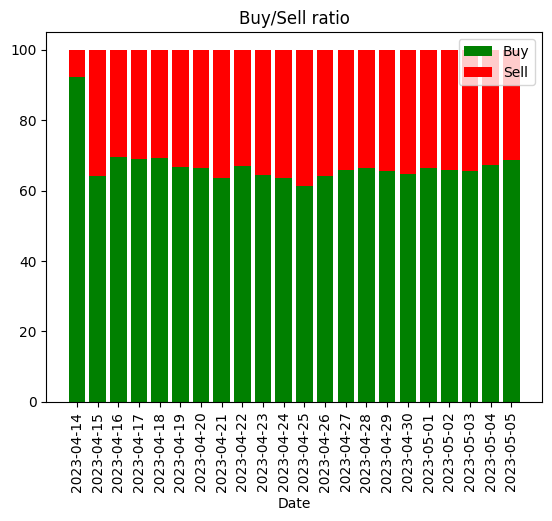

In [106]:
# Ratio of buy and sell
def get_buy_percentage(row):
  return round((row['tx_buy_count'] / (row['tx_buy_count'] + row['tx_sell_count'])) * 100, 2)

df_swap_ratio = df_counter[['block_time', 'tx_buy_count', 'tx_sell_count']]
df_swap_ratio = df_swap_ratio.assign(buy_percentage = lambda x: get_buy_percentage(x))
df_swap_ratio = df_swap_ratio.assign(sell_percentage = lambda x: 100 - x['buy_percentage'])

_, ax = plt.subplots()
ax.bar(df_swap_ratio['block_time'], df_swap_ratio['buy_percentage'], color='g')
ax.bar(df_swap_ratio['block_time'], df_swap_ratio['sell_percentage'], bottom=df_swap_ratio['buy_percentage'], color='r')

ax.set_xlabel('Date')
ax.set_title('Buy/Sell ratio')
ax.legend(['Buy', 'Sell'])

plt.xticks(rotation=90)
plt.show()



Number of transactions: 539,497 transactions
Number of swap transactions: 462,879 transactions
Swap ratio: 85.8%


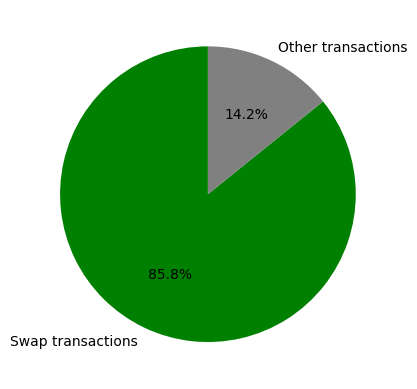

In [11]:
# Swap rate
df_unique_hash = df.drop_duplicates(['hash'])
number_of_txs = len(df_unique_hash)
number_of_swap_txs = len(df_unique_hash[df_unique_hash['project'].notna()])

swap_rate = round((number_of_swap_txs / number_of_txs) * 100, 2)

print('Number of transactions: {:,} transactions'.format(number_of_txs))
print('Number of swap transactions: {:,} transactions'.format(number_of_swap_txs))
print('Swap ratio: {}%'.format(swap_rate))

plt.pie(
  [swap_rate, 100 - swap_rate],
  labels=['Swap transactions', 'Other transactions'],
  colors=['green', 'gray'],
  startangle = 90,
  autopct='%1.1f%%'
)
plt.show()

<Axes: title={'center': 'PEPE Daily Volume'}, xlabel='Block time', ylabel='Volume USD'>

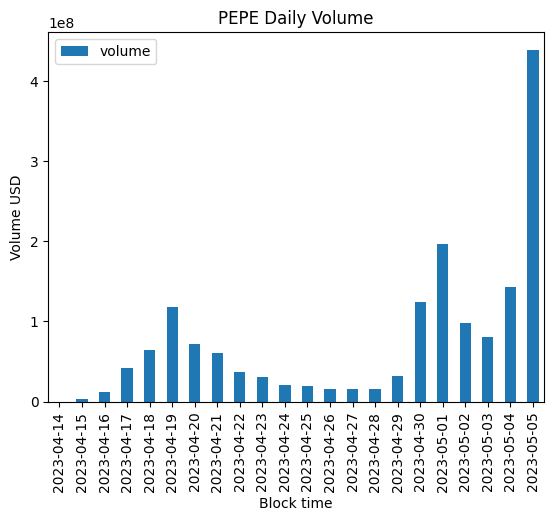

In [12]:
# Daily and cummulative volume
df_swaps = df_with_floor_time_by_day[df_with_floor_time_by_day['project'].notna()]
df_volume = df_swaps \
  .groupby('block_time')['amount_usd'] \
  .sum() \
  .reset_index(name='volume')

df_volume['cummulative_volume'] = df_volume['volume'] \
  .cumsum()

df_volume.plot(
  kind='bar',
  title='PEPE Daily Volume',
  x='block_time',
  y='volume',
  xlabel='Block time',
  ylabel='Volume USD'
)

         project  total_volume
3      uniswap-2  9.820401e+08
4      uniswap-3  6.580576e+08
2  pancakeswap-3  1.878048e+06
0         DODO-0  3.120346e+05
1     maverick-1  1.169335e+05


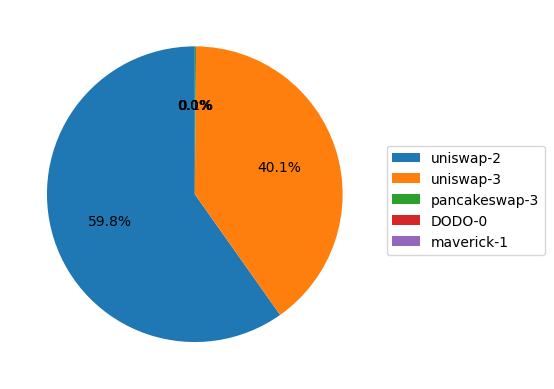

In [13]:
# Market share
df_market_share = df_swaps \
  .groupby('project')['amount_usd'] \
  .sum() \
  .reset_index(name='total_volume') \
  .sort_values(by=['total_volume'], ascending=False)

print(df_market_share)

plt.pie(
  df_market_share['total_volume'],
  startangle = 90,
  autopct='%1.1f%%'
)
plt.legend(labels=df_market_share['project'], bbox_to_anchor=(1, 0.65))
plt.show()

Text(1, 40, 'ROI 380,741x')

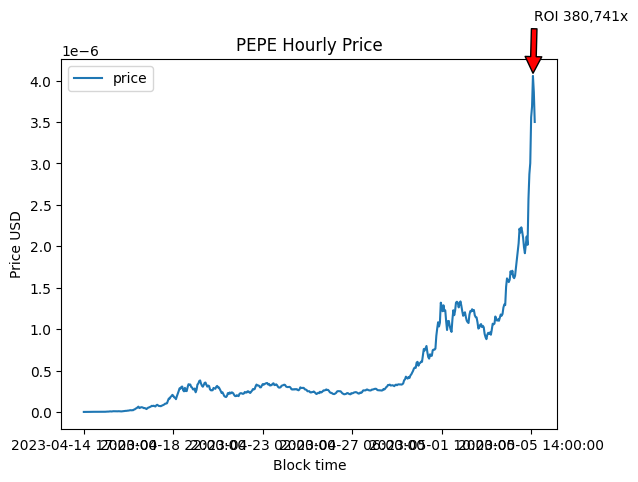

In [14]:
# Hourly price
df_price = df_with_floor_time_by_hour[df_with_floor_time_by_hour['project'].notna()] \
  .assign(price = lambda x:
    x['amount_usd'] / df.apply(
    lambda x: x['token_bought_amount']
      if x['token_bought_symbol'] == 'PEPE'
      else x['token_sold_amount']
    , axis=1
))

df_price = df_price.groupby('block_time')['price'].mean().reset_index()

init_price = df_price['price'].iloc[0]
highest_price = df_price['price'].max()
highest_price_index = df_price['price'].idxmax()
roi = round(highest_price / init_price)

# Draw figure
fig_price = df_price.plot(
  kind='line',
  title='PEPE Hourly Price',
  x='block_time',
  y='price',
  xlabel='Block time',
  ylabel='Price USD'
)
fig_price.annotate(
  'ROI {:,}x'.format(roi),
  xy=(highest_price_index, highest_price),
  xycoords='data',
  xytext=(1, 40),
  textcoords='offset points',
  arrowprops=dict(facecolor='red', shrink=0.05),
)


In [15]:
# Address by volume
def get_number_of_address_by_volume(min, max):
  return len(df_address_volume[
    (df_address_volume['total_volume'] > min)
    & (df_address_volume['total_volume'] <= max)
  ])

df_address_volume = df[df['project'].notna()]

df_address_volume = df_address_volume \
  .groupby('tx_from')['amount_usd'] \
  .sum() \
  .reset_index(name='total_volume') \
  .sort_values(by=['total_volume'], ascending=False) 

for i in range(4):
  min = pow(10, 0 if i == 0 else i + 2)
  max = pow(10, i + 3)
  num_address = get_number_of_address_by_volume(min, max)
  ratio = round((num_address / len(df_address_volume)) * 100, 2)
  print('Number of address with volume (${:,}-${:,}]: {:,} addresses ({}%)'
    .format(min, max, num_address, ratio)
  )

print('\n')
print('Top 10 address with highest trading volume:')
df_address_volume \
    .rename(columns={'tx_from': 'Address', 'total_volume': 'Volume ($)'}) \
    .reset_index(drop=True) \
    .head(10) \
    .style.format({'Volume ($)': '${:,.0f}'})

Number of address with volume ($1-$1,000]: 77,791 addresses (65.04%)
Number of address with volume ($1,000-$10,000]: 30,846 addresses (25.79%)
Number of address with volume ($10,000-$100,000]: 9,063 addresses (7.58%)
Number of address with volume ($100,000-$1,000,000]: 1,431 addresses (1.2%)


Top 10 address with highest trading volume:


,Address,Volume ($)
0,0xae2fc483527b8ef99eb5d9b44875f005ba1fae13,"$429,820,523"
1,0x758e8229dd38cf11fa9e7c0d5f790b4ca16b3b16,"$42,630,666"
2,0xb58555fcba6479fced7de1485eb054943a09af7b,"$31,306,705"
3,0xd985c35f566c9de55df16ade36852b0c40f4bf59,"$24,442,554"
4,0x85b4ad5f4f563e549a33d5b0b23c1091aa03d2ac,"$22,096,868"
5,0xf1d307906edc902dc2c392af2880f43a55d3583a,"$20,068,704"
6,0xa009fa1ac416ec02f6f902a3a4a584b092ae6123,"$17,225,437"
7,0xb722e4d12d4c0ec0309856e32c4f7df9c05a11fb,"$15,950,469"
8,0x33c6b73432b3aea0c1725e415cc40d04908b85fd,"$15,814,872"
9,0x76f36d497b51e48a288f03b4c1d7461e92247d5e,"$14,691,030"


In [53]:
pd.set_option('mode.chained_assignment', None)

# RealizedPnl of Address (Not include transactions on centralized exchanges or transfers to other wallets)
df_address_profit = df[df['project'].notna()]

df_address_profit['realized_pnl'] = df_address_profit.apply(
  lambda x: -x['amount_usd']
    if x['token_bought_symbol'] == 'PEPE'
    else x['amount_usd']
  , axis=1
)

print('Top 10 address by RealizedPnL')
pd.pivot_table(
  df_address_profit,
  index=['tx_from'],
  aggfunc={'realized_pnl': np.sum, 'hash': len}
).rename(columns={'tx_from': 'Address', 'realized_pnl': 'RealizedPnL ($)', 'hash': 'Number of swaps'}) \
  .sort_values(['RealizedPnL ($)'], ascending=False) \
  .head(10) \
  .style.format({'RealizedPnL ($)': '${:,.0f}'})


Top 10 address by RealizedPnL


,Number of swaps,RealizedPnL ($)
tx_from,,
0xb722e4d12d4c0ec0309856e32c4f7df9c05a11fb,626,"$15,950,469"
0x2dde64018ba03931e518dda4dd0d18affb12effa,416,"$2,422,454"
0x45cf108e79374ad324904c22847569609f48e33c,109,"$1,967,108"
0x4a2c786651229175407d3a2d405d1998bcf40614,94,"$1,809,766"
0xfd9ce48c96617bf6ccc7c37044b1a22638b71e02,64,"$1,737,437"
0x0653be9558c66fd0f74b26daed3b3cdb3b493144,120,"$1,582,926"
0xa21740833858985e4d801533a808786d3647fb83,608,"$1,531,752"
0x30c5312d9cf0d873994f000e72f1cbf561d0209c,171,"$1,494,484"
0xc252ceec3ad24c47657638c323d96249a9f1b42a,308,"$1,483,926"


                                              from  total_fee_paid
87926   0xae2fc483527b8ef99eb5d9b44875f005ba1fae13     1295.146834
59273   0x758e8229dd38cf11fa9e7c0d5f790b4ca16b3b16      102.454062
60015   0x76f36d497b51e48a288f03b4c1d7461e92247d5e       94.644151
92337   0xb722e4d12d4c0ec0309856e32c4f7df9c05a11fb       90.652916
67475   0x85b4ad5f4f563e549a33d5b0b23c1091aa03d2ac       46.108396
60396   0x77ad3a15b78101883af36ad4a875e17c86ac65d1       42.779672
91507   0xb58555fcba6479fced7de1485eb054943a09af7b       42.748709
121799  0xf1d307906edc902dc2c392af2880f43a55d3583a       42.121477
60118   0x77223f67d845e3cbcd9cc19287e24e71f7228888       28.524365
59463   0x75e89d5979e4f6fba9f97c104c2f0afb3f1dcb88       26.828963


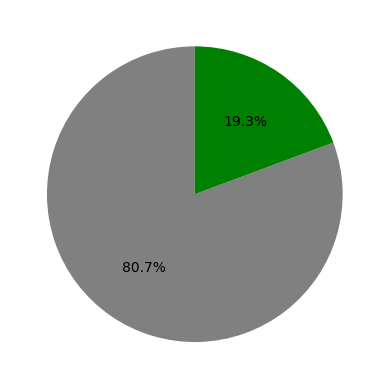

In [85]:
# Top address paid fee
df_top_fee_paid = df.drop_duplicates(['hash']) \
  .groupby('from')['tx_fee'] \
  .sum() \
  .reset_index(name='total_fee_paid') \
  .sort_values(by=['total_fee_paid'], ascending=False) \
  .head(10)

print(df_top_fee_paid)

plt.pie(
  [total_eth_paid, df_top_fee_paid['total_fee_paid'].sum()],
  colors=['gray', 'g'],
  startangle = 90,
  autopct='%1.1f%%'
)
plt.show()

In [ ]:
# Show all swap transactions of address
address = '0xb722e4d12d4c0ec0309856e32c4f7df9c05a11fb'

df[
  (df['project'].notna()) &
  (df['tx_from'] == address)
][['block_time', 'hash', 'token_bought_symbol', 'token_sold_symbol', 'amount_usd']]
